In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import copy
import numpy as np

In [6]:
# Data preparation
# Data transformations
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4865, 0.4409], std=[0.2673, 0.2564, 0.2762]),
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4865, 0.4409], std=[0.2673, 0.2564, 0.2762]),
])

# Download CIFAR-100 dataset
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

# Data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


Files already downloaded and verified
Files already downloaded and verified


In [7]:
# model setup
# Load pre-trained ResNet-18 model
model = torchvision.models.resnet18(pretrained=True)

# Modify the final layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 100)

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# training
num_epochs = 10  # change epochs number

train_acc_history = []
val_acc_history = []

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
            data_loader = train_loader
        else:
            model.eval()   # Set model to evaluate mode
            data_loader = test_loader

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            # Track gradients only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / len(data_loader.dataset)
        epoch_acc = running_corrects.double() / len(data_loader.dataset)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        if phase == 'train':
            train_acc_history.append(epoch_acc.item())
        else:
            val_acc_history.append(epoch_acc.item())

print(f'Best val Acc: {best_acc:.4f}')

# Load best model weights
model.load_state_dict(best_model_wts)

# Save the model checkpoint
torch.save(model.state_dict(), 'resnet18_cifar100.pth')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
----------
train Loss: 1.5325 Acc: 0.5973
val Loss: 0.9877 Acc: 0.7027
Epoch 2/10
----------
train Loss: 0.7061 Acc: 0.7863
val Loss: 0.8525 Acc: 0.7468
Epoch 3/10
----------
train Loss: 0.5004 Acc: 0.8485
val Loss: 0.7865 Acc: 0.7643
Epoch 4/10
----------
train Loss: 0.3571 Acc: 0.8924
val Loss: 0.7421 Acc: 0.7822
Epoch 5/10
----------
train Loss: 0.2548 Acc: 0.9259
val Loss: 0.7348 Acc: 0.7906
Epoch 6/10
----------
train Loss: 0.1857 Acc: 0.9487
val Loss: 0.7157 Acc: 0.7940
Epoch 7/10
----------
train Loss: 0.1302 Acc: 0.9662
val Loss: 0.7337 Acc: 0.7910
Epoch 8/10
----------
train Loss: 0.0928 Acc: 0.9780
val Loss: 0.7041 Acc: 0.8078
Epoch 9/10
----------
train Loss: 0.0608 Acc: 0.9882
val Loss: 0.7126 Acc: 0.8044
Epoch 10/10
----------
train Loss: 0.0457 Acc: 0.9924
val Loss: 0.7042 Acc: 0.8138
Best val Acc: 0.8138


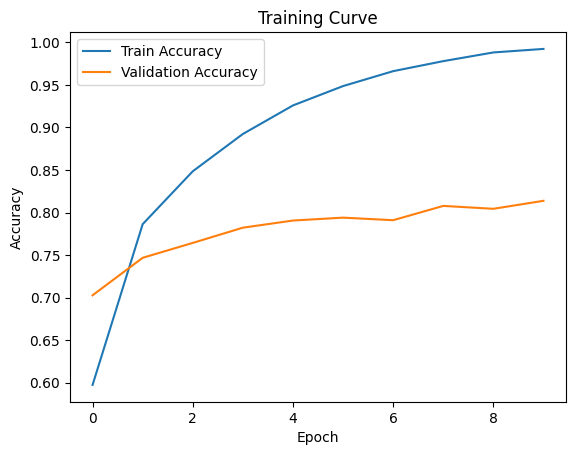

In [8]:
# Training graph
# Plot training and validation accuracy
plt.figure()
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Curve')
plt.show()

In [26]:
# QAT process
# fixed-point quantization function
def fixed_point_quantize(x, int_bits=4, frac_bits=4):
    qmin = -2**(int_bits)
    qmax = 2**(int_bits) - 2**(-frac_bits)
    scale = 2 ** frac_bits
    x = torch.clamp(x, qmin, qmax)
    x_quantized = torch.round(x * scale) / scale
    return x_quantized

# Modify the model for the QAT
class QuantizedConvLayer(nn.Module):
    def __init__(self, conv_layer, int_bits=4, frac_bits=4):
        super(QuantizedConvLayer, self).__init__()
        self.conv = conv_layer
        self.int_bits = int_bits
        self.frac_bits = frac_bits

    def forward(self, x):
        # Quantize input activation
        x = fixed_point_quantize(x, self.int_bits, self.frac_bits)
        # Convolution
        x = self.conv(x)
        # Quantize output activation
        x = fixed_point_quantize(x, self.int_bits, self.frac_bits)
        return x

class QuantizedLinearLayer(nn.Module):
    def __init__(self, linear_layer, int_bits=4, frac_bits=4):
        super(QuantizedLinearLayer, self).__init__()
        self.fc = linear_layer
        self.int_bits = int_bits
        self.frac_bits = frac_bits

    def forward(self, x):
        # Quantize input activation
        x = fixed_point_quantize(x, self.int_bits, self.frac_bits)
        # Linear
        x = self.fc(x)
        # Quantize output activation
        x = fixed_point_quantize(x, self.int_bits, self.frac_bits)
        return x

# Apply quantization function
def apply_quantization(model, int_bits=4, frac_bits=4):
    for name, module in model.named_children():
        if isinstance(module, nn.Conv2d):
            setattr(model, name, QuantizedConvLayer(module, int_bits, frac_bits))
        elif isinstance(module, nn.Linear):
            setattr(model, name, QuantizedLinearLayer(module, int_bits, frac_bits))
        elif isinstance(module, nn.Sequential) or isinstance(module, nn.Module):
            apply_quantization(module, int_bits, frac_bits)




In [27]:
# Re-instantiate the model
model = torchvision.models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 100)
model = model.to(device)

# Load the saved model
model.load_state_dict(torch.load('resnet18_cifar100.pth'))

# Apply quantization
apply_quantization(model)
model = model.to(device)

# Define new optimizer for fine-tuning
optimizer_qat = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler_qat = optim.lr_scheduler.StepLR(optimizer_qat, step_size=10, gamma=0.1)

num_epochs_qat = 20  # Fine-tuning epochs

train_acc_history_qat = []
val_acc_history_qat = []

best_model_wts_qat = copy.deepcopy(model.state_dict())
best_acc_qat = 0.0

for epoch in range(num_epochs_qat):
    print(f'QAT Epoch {epoch+1}/{num_epochs_qat}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
            data_loader = train_loader
        else:
            model.eval()   # Set model to evaluate mode
            data_loader = test_loader

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer_qat.zero_grad()

            # Forward
            # Track gradients only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer_qat.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        if phase == 'train':
            scheduler_qat.step()

        epoch_loss = running_loss / len(data_loader.dataset)
        epoch_acc = running_corrects.double() / len(data_loader.dataset)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Deep copy the model
        if phase == 'val' and epoch_acc > best_acc_qat:
            best_acc_qat = epoch_acc
            best_model_wts_qat = copy.deepcopy(model.state_dict())

        if phase == 'train':
            train_acc_history_qat.append(epoch_acc.item())
        else:
            val_acc_history_qat.append(epoch_acc.item())

print(f'Best Quantized val Acc: {best_acc_qat:.4f}')

# Save the model after quantization
# Load best model weights
model.load_state_dict(best_model_wts_qat)

# Save the quantized model checkpoint
torch.save(model.state_dict(), 'resnet18_cifar100_quantized.pth')


QAT Epoch 1/20
----------


<ipython-input-27-bef76b4eafb4>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet18_cifar100.pth'))


train Loss: 0.0599 Acc: 0.9901
val Loss: 0.7048 Acc: 0.8065
QAT Epoch 2/20
----------
train Loss: 0.0601 Acc: 0.9903
val Loss: 0.7083 Acc: 0.8080
QAT Epoch 3/20
----------
train Loss: 0.0603 Acc: 0.9902
val Loss: 0.7042 Acc: 0.8078
QAT Epoch 4/20
----------
train Loss: 0.0611 Acc: 0.9905
val Loss: 0.7082 Acc: 0.8033
QAT Epoch 5/20
----------
train Loss: 0.0615 Acc: 0.9900
val Loss: 0.7083 Acc: 0.8059
QAT Epoch 6/20
----------
train Loss: 0.0634 Acc: 0.9898
val Loss: 0.7095 Acc: 0.8049
QAT Epoch 7/20
----------
train Loss: 0.0624 Acc: 0.9903
val Loss: 0.7129 Acc: 0.8050
QAT Epoch 8/20
----------
train Loss: 0.0641 Acc: 0.9898
val Loss: 0.7014 Acc: 0.8093
QAT Epoch 9/20
----------
train Loss: 0.0638 Acc: 0.9902
val Loss: 0.7011 Acc: 0.8081
QAT Epoch 10/20
----------
train Loss: 0.0647 Acc: 0.9902
val Loss: 0.7033 Acc: 0.8068
QAT Epoch 11/20
----------
train Loss: 0.0651 Acc: 0.9901
val Loss: 0.7072 Acc: 0.8063
QAT Epoch 12/20
----------
train Loss: 0.0641 Acc: 0.9903
val Loss: 0.7055 Acc

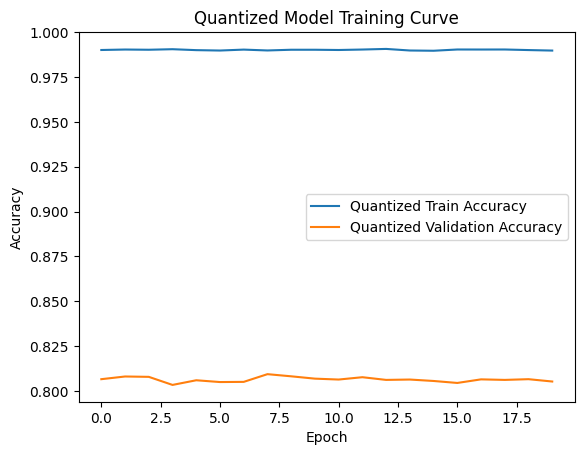

Quantized Model Test Accuracy: 0.8093


In [28]:
# Plot training and validation accuracy for quantized model
plt.figure()
plt.plot(train_acc_history_qat, label='Quantized Train Accuracy')
plt.plot(val_acc_history_qat, label='Quantized Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Quantized Model Training Curve')
plt.show()

# Evaluate quantized model
model.eval()
running_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        running_corrects += torch.sum(preds == labels.data)

test_acc = running_corrects.double() / len(test_loader.dataset)
print(f'Quantized Model Test Accuracy: {test_acc:.4f}')
